In [121]:
import pandas as pd
import numpy as np
import spacy
# import gensim
import nltk
# from nltk.corpus import stopwords
from string import punctuation
# from nltk import SnowballStemmer
# from collections import Counter
from collections import defaultdict

# import numba
# from numba.experimental import jitclass
# from numba import jit,njit,cuda
import re
import os
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# plt.style.use("ggplot")

#nltk.download("stopwords")

nlp = spacy.load("en_core_web_sm")
# stopwords = list(stopwords.words("english"))
punt = "".join([ele for ele in punctuation])
# no_word = stopwords+ punt
# stemmer = SnowballStemmer("english")

In [2]:
PATH_FIND = re.compile(r".*repository.")
rep_path = re.search(PATH_FIND,os.getcwd()).group()

In [3]:
df = pd.read_csv(rep_path+"\\99 generated csv\\ch 2\\raw_all_component.csv ")

# Language Model

In [72]:
class LanguageModel(object):
    def __init__(self, df, name_abstract_col ="abstract", name_token_col= None ):
        self.abstract = df[name_abstract_col]
        if name_token_col == None:
            self.corpus = [[token.text for token in nlp(new_sentence)] for new_sentence in self.abstract]
        else:
            self.corpus = list(df[name_token_col].apply(lambda x: re.sub("'", "",x.strip('][')).split(", ")))
        self.START = '_***_'
        self.STOP = '_STOP_'
        self.counts = None
        
        
        
    def training(self, smoothing = 0.001):
        smoothing = smoothing
        START = self.START
        STOP = self.STOP

        # map from (u, v) to w = (w|u,v)
        counts = defaultdict(lambda: defaultdict(lambda: smoothing))

        # collect counts for MLE
        for sentence in self.corpus:
            # include special tokens for start and the end of sentence
            tokens = [self.START, self.START] + sentence + [self.STOP]
            for u, v, w in nltk.ngrams(tokens, 3):
                counts[(u, v)][w] += 1
        self.counts = counts
        
        
    def generate(self,initial=[]):
        result = [self.START, self.START] + initial
        for i in range(len(result)-1):
            try:
                next_word = self.sample_next_word(result[-(i+2)], result[-(i+1)])
            except ValueError:
                pass
        result.append(next_word)
        while next_word != self.STOP:
            try:
                next_word = self.sample_next_word(result[-2], result[-1])
            except ValueError:
                next_word = self.sample_next_word(self.START, result[-1])
            result.append(next_word)
        return ' '.join(result[2:-1])
    
    

    def sample_next_word(self,u, v):
        """
        sample a word w based on the history (u, v)
        """
        # separate word and their counts into separate variables
        keys, values = zip(*self.counts[(u, v)].items())

        # normalize the counts into a probability distribution
        values = np.array(values)
        values /= values.sum() # create probability distro

        # this is the meat of the function
        sample = np.random.multinomial(1, values) # pick one position

        return keys[np.argmax(sample)]

In [73]:
LM = LanguageModel(df, "abstract","tokens")

In [74]:
LM.training(smoothing=0.001)

In [77]:
LM.generate()

'Methods systems computer program product computer system A free running stoppable clocks maintain cycle accurate cycle reproducible execution simulation target system gate flags stored otherwise unused bits packet routing switching network include processor host firmware interface configured display first two dimensional surface k levels similarity pyramid'

# W2V and D2V

In [78]:
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION


In [82]:
class W2V (object):
    def __init__(self, df, name_abstract_col ="abstract", name_token_col= None):
        self.abstract = df[name_abstract_col]
        if name_token_col == None:
            self.corpus = [[token.text for token in nlp(new_sentence)] for new_sentence in self.abstract]
        else:
            self.corpus = list(df[name_token_col].apply(lambda x: re.sub("'", "",x.strip('][')).split(", ")))
        self.w2v_model = None
        
        
    def setmodel(self,vector_size_=100,window_=15,sample_=0.0001,epochs_=200,negative_=5,min_count_=1,workers_=-1,hs_=0,seed_= 1):
        
        
        w2v_model = Word2Vec(
                    vector_size=vector_size_, # vector size
                     window=window_, # window for sampling
                     sample=sample_, # subsampling rate
                     epochs=epochs_, # iterations
                     negative=negative_, # negative samples
                     min_count=min_count_, # minimum threshold
                     workers=workers_, # parallelize to all cores
                     hs=hs_, # no hierarchical softmax
                     seed = seed_
        
        )
        
        w2v_model.build_vocab(self.corpus)
        
        # train the model
        w2v_model.train(self.corpus, 
                        total_examples=w2v_model.corpus_count, 
                        epochs=w2v_model.epochs)
        
        self.w2v_model = w2v_model
    
    def print_voc(self):
        return  self.w2v_model.wv.index_to_key
        
    def most_similar (self, word, topn_ = 3):
        return self.w2v_model.wv.most_similar(positive=word, topn=topn_)
        
        
        
        

In [83]:
from gensim.models.doc2vec import FAST_VERSION
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [84]:
class D2V (object):
    def __init__(self, df):
        self.df = df 
        self.corpus = []
        self.d2v_model = None
        
    
    def getcorpus(self, value ,text_="abstract" ):
        for label, text in zip(df[value] ,df[text_]):
            self.corpus.append(TaggedDocument(words=text.split(), 
                                     tags=[str(label)]))

    def getmodel(self, vector_size_=100,window_=15,sample_=0.0001,epochs_=200,negative_=5,
                 min_count_=1,workers_=-1,hs_=0,seed_= 1,dbow_words_= 1, dm_=0):
        # initialize model
        d2v_model = Doc2Vec(vector_size=vector_size_, 
                            window=window_,
                            hs=hs_,
                            sample=sample_,
                            negative=negative_,
                            min_count=min_count_,
                            workers=workers_,
                            epochs=epochs_,
                            seed = seed_,
                            dm=dm_, 
                            dbow_words=dbow_words_)

        # build the vocabulary
        d2v_model.build_vocab(self.corpus)

        # train the model
        d2v_model.train(self.corpus, 
                        total_examples=d2v_model.corpus_count, 
                        epochs=d2v_model.epochs)

        self.d2v_model = d2v_model
    
    def most_similar_word(self, label_name, topn_= 5 ):
        return self.d2v_model.wv.most_similar([d2v_model.docvecs[label_name]], topn = topn_)
    
    def most_similar_doc(self, label_name, topn_=5):
        return self.d2v_model.dv.most_similar(label_name, topn=topn_)

In [93]:
d2v = D2V(df)

d2v.getcorpus(value="kind")

d2v.getmodel(vector_size_= 1000,sample_= 0.01, epochs_=500, min_count_=3 ,seed_= 112, hs_=1, window_ = 25)

d2v.most_similar_doc("B1")

[('E', 0.021376626566052437),
 ('A', 0.013672355562448502),
 ('B2', 0.004068851936608553)]

In [89]:
d2v = D2V(df)

d2v.getcorpus(value="category")

d2v.getmodel(vector_size_= 1000,sample_= 0.01, epochs_=500, min_count_=2 ,seed_= 242, hs_=1, window_ = 25)

d2v.most_similar_doc("inventional")

[('additional', 0.01037394255399704)]

In [ ]:
d2v = D2V(df)

d2v.getcorpus(value="category")

d2v.getmodel(vector_size_= 1000,sample_= 0.01, epochs_=500, min_count_=2 ,seed_= 242, hs_=1, window_ = 25)

d2v.most_similar_doc("inventional")

In [97]:
d2v = D2V(df)

d2v.getcorpus(value="issue_date_year")

d2v.getmodel(vector_size_= 1000,sample_= 0.01, epochs_=500, min_count_=2 ,seed_= 242, hs_=1, window_ = 25)

d2v.most_similar_doc("1976")

[('2004', 0.08271179348230362),
 ('1990', 0.05768097937107086),
 ('2011', 0.05751805379986763),
 ('2001', 0.056288816034793854),
 ('2010', 0.052841830998659134)]

In [98]:
d2v.most_similar_doc("2000")

[('2013', 0.06771913915872574),
 ('1984', 0.06656211614608765),
 ('1999', 0.05630718916654587),
 ('1990', 0.0438900887966156),
 ('2003', 0.03995659947395325)]

# Classifier

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
df.lemmas.apply(lambda x: re.sub(",","",re.sub("'", "",x.strip(']['))))

0        A method apparatus adding fill clock pulses an...
1          A rotary cutting blade assembly removing rub...
2        A field sequential liquid crystal display appa...
3        Disclosed system method collecting trace data ...
4          A fire truck characterized reduced operating...
                               ...                        
49995    A touch sensor panel including plurality drive...
49996    An open cable set top box diagnosing system po...
49997    A tunable filter circuit inputs IN1 IN2 output...
49998    A method disclosed forming semiconductor devic...
49999    A lighting device vehicle may include light so...
Name: lemmas, Length: 50000, dtype: object

In [134]:
punt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [169]:
class Classifier:
    def __init__(self, df,name_token_col,abstract = "abstract" ):
        self.df = df
        self.abstract= df[abstract].apply(lambda x: re.sub(r'[0-9]', "", x))
        # self.lemmas = df["lemmas"].apply(lambda x: re.sub(",","",re.sub("'", "",x.strip(']['))))
        self.df_token = None
        #self.corpus = df[name_token_col].apply(lambda x: re.sub("'", "",x.strip('][')).split(", "))
        self.X_train = None
        self.y_train = None
        self.X_validation = None
        self.y_validation = None
        self.X_test = None
        self.y_test = None
        self.col_filt = [ "kind", "num_claims", "subsection_id","xi_real","category","cites","permno","issue_date_year"]
        self.model = None
        self.history = None
        
    def correct_lemmas(self, x):
        l = []
        x = re.sub(" ","",re.sub(r'[^\x00-\x7f]',"",re.sub(r"[0-9]","",re.sub("'", "",x.strip(']['))))).split(", ")
        for ele in x :
            if len(ele) >= 3:
                l.append(re.sub(r".*[punctuation]","",ele))
        return " ".join(l)
    
    def create_lemmas(self):
        self.lemmas = self.df["lemmas"].apply(lambda x: self.correct_lemmas(x))
        
    def preparation_normal_dataset(self):
        temp = self.df.filter(self.col_filt, axis = 1)
        cat = temp.select_dtypes(object)
        num = temp.drop(cat.columns, axis = 1)
        cat = pd.get_dummies(cat)
        self.df = pd.merge(num, cat, left_index=True, right_index=True)
    
    def preparation_token_dataset(self):
        vec = CountVectorizer(ngram_range=(1,1), 
                              max_df=1.0, 
                              min_df=1, 
                              analyzer="char")
        
        vectorized = vec.fit_transform(self.lemmas)
        X = vectorized.toarray()
        self.df_token = pd.DataFrame( X ,columns=vec.get_feature_names_out())
        
    def train_test(self, case = "token"):
        if case != "token":
            scaler = StandardScaler()

            X = self.df.drop(["category_inventional", "category_additional"], axis = 1)
            y = self.df["category_inventional"] # 1= is invational, 0 = is additional 
        else: 
            scaler = StandardScaler()

            X = self.df_token
            y = self.df["category"].apply(lambda x: np.where(x=="additional", 0,1)) # 1= is invational, 0 = is additional 

        self.X_train, X_half, self.y_train, y_half = train_test_split(X,y,test_size=0.3, random_state=1998)
        
        self.X_train = scaler.fit_transform(self.X_train)
        
        self.X_validation, self.X_test, self.y_validation, self.y_test = train_test_split(X_half,y_half,test_size=0.5, random_state=1996)
        
        self.X_validation = scaler.transform(self.X_validation)
        self.X_test = scaler.transform(self.X_test)
        
        
    def setNN(self, learning_rate = 0.001):
        
        nn = models.Sequential()
        nn.add(layers.InputLayer(self.X_train.shape[1]))
        nn.add(layers.Dense(64,activation="relu"))
        nn.add(layers.Dropout(0.25))
        nn.add(layers.Dense(128,activation="relu"))
        nn.add(layers.Dropout(0.25))
        # nn.add(layers.Dense(512,activation="relu"))
        # nn.add(layers.Dropout(0.25))
        nn.add(layers.Dense(1, activation="sigmoid"))
        
        nn.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate, decay = 1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())
        return nn 
    
    def fit(self, batch_size = 256, epochs = 20, learning_rate = 0.001): 
        self.model = self.setNN(learning_rate = learning_rate)
        self.history = self.model.fit(self.X_train, self.y_train,
 
                   validation_data=(self.X_validation, self.y_validation),
                    
                   # it will use 'batch_size' number
                   # of examples per example
                   batch_size=batch_size,
                   epochs=epochs  # total epoch
                    )
    def prediction(self, threshold = 0.5):
        y_pred = np.where(self.model.predict(self.X_test)>= threshold, 1,0)
        
        print(classification_report(self.y_test, y_pred))
        
    def plot_training(self):
        
        acc = self.history.history['binary_accuracy']
        val_acc = self.history.history['val_binary_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        
        epochs = range(1, len(acc) + 1)
        
        fig, ax = plt.subplots(1,2,figsize =(18,5) )
        
        ax[0].plot(epochs, acc, 'bo', label='Training acc')
        ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
        ax[0].set_title('Training and validation accuracy')
        ax[0].legend()

        #plt.figure()

        ax[1].plot(epochs, loss, 'bo', label='Training loss')
        ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
        ax[1].set_title('Training and validation loss')
        ax[1].legend()

        plt.show()
        

In [170]:
cl = Classifier(df[:10000], "tokens")

In [171]:
cl.create_lemmas()

In [172]:
cl.preparation_token_dataset()

In [173]:
cl.df_token

,"""",#,%,&,(,),+,",",-,.,...,q,r,s,t,u,v,w,x,y,z
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
cl.train_test()

In [175]:
cl.fit(batch_size=128, epochs = 50, learning_rate=0.0001)

Epoch 1/50
55/55 [==============================] - 1s 6ms/step - loss: 0.6911 - binary_accuracy: 0.6181 - val_loss: 0.6924 - val_binary_accuracy: 0.6260
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - binary_accuracy: 0.6357 - val_loss: 0.6858 - val_binary_accuracy: 0.6273
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6802 - binary_accuracy: 0.6419 - val_loss: 0.6805 - val_binary_accuracy: 0.6273
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6712 - binary_accuracy: 0.6431 - val_loss: 0.6770 - val_binary_accuracy: 0.6273
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6700 - binary_accuracy: 0.6436 - val_loss: 0.6741 - val_binary_accuracy: 0.6307
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6675 - binary_accuracy: 0.6440 - val_loss: 0.6718 - val_binary_accuracy: 0.6293
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.65

In [176]:
cl.prediction(threshold=0.50)

47/47 [==============================] - 0s 956us/step
              precision    recall  f1-score   support

           0       0.44      0.01      0.01       540
           1       0.64      0.99      0.78       960

    accuracy                           0.64      1500
   macro avg       0.54      0.50      0.40      1500
weighted avg       0.57      0.64      0.50      1500



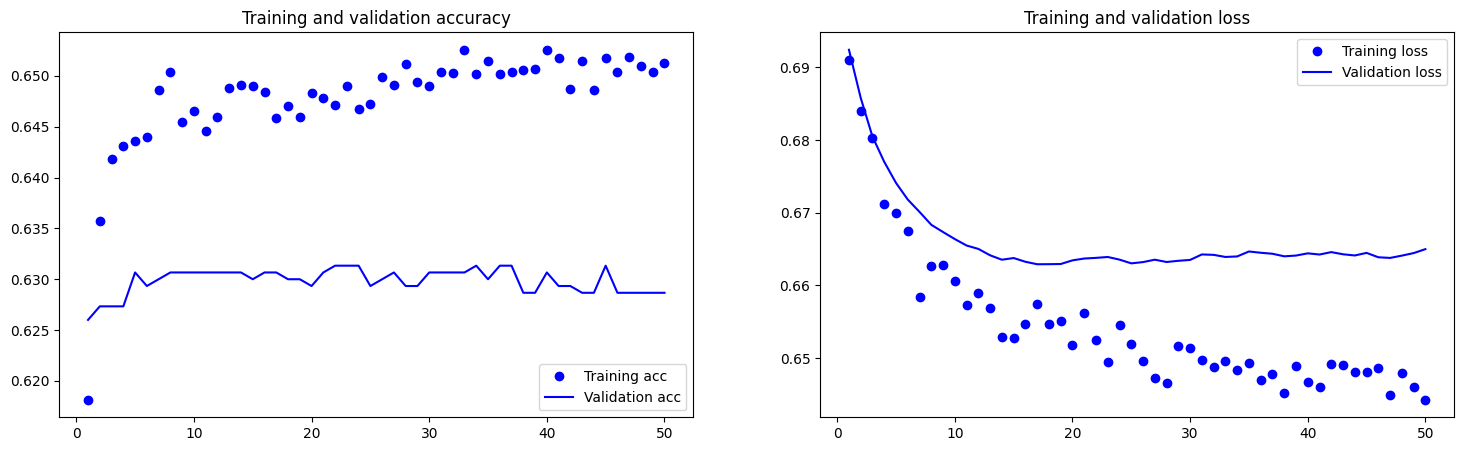

In [177]:
cl.plot_training()